In [1]:
import numpy as np, tensorflow as tf, pandas as pd
import keras, sklearn, pickle
from keras.preprocessing import text, sequence
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model("bidirectional-gru.hdf5")
graph = tf.get_default_graph()

with open('bidirectional-gru-tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [3]:
test = pd.read_csv("test.csv")
sub = pd.read_csv("submission.csv")

In [4]:
toxic_word_series = {'gay' : [], 'shit' : [], 'piss' : [], 'fuck' : [], 'bitch' : [], 'whore' : [], 'faggot' : [], 'nigger' : []}
X_test = test["comment_text"].str.lower()
for word in toxic_word_series:
    toxic_word_series[word] = X_test.copy().apply(lambda x: word + ' ' + x)

In [5]:
y_preds = {'gay' : None, 'shit' : None, 'piss' : None, 'fuck' : None, 'bitch' : None, 'whore' : None, 'faggot' : None, 'nigger' : None}

for word in y_preds:
    seq=tokenizer.texts_to_sequences(toxic_word_series[word])
    seq=sequence.pad_sequences(seq,maxlen=150)

    with graph.as_default():
        y_preds[word] = model.predict(seq,verbose=1)

153164/153164 [==============================] - 389s 3ms/step


In [8]:
#del sub['id']

sub_vals = sub.values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for word in y_preds:
    y_preds[word] = pd.DataFrame(y_preds[word] - sub_vals, columns=labels) 

In [9]:
import seaborn as sns
import matplotlib as plt

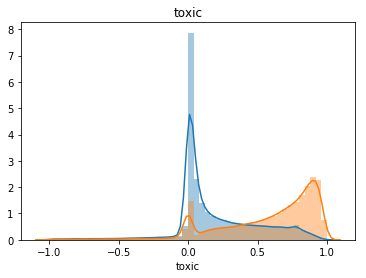

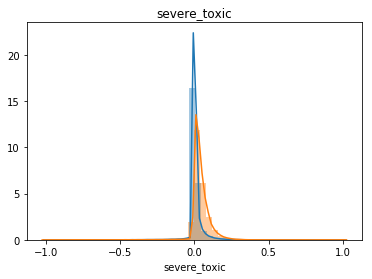

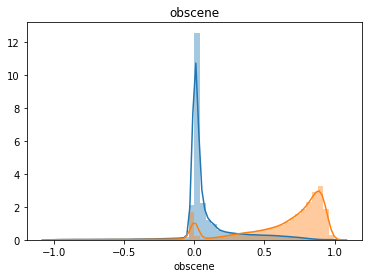

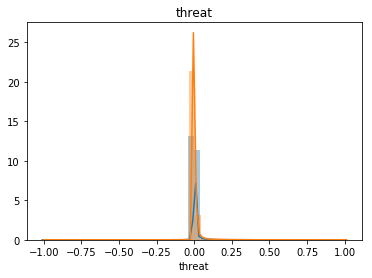

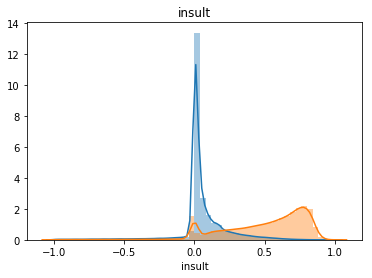

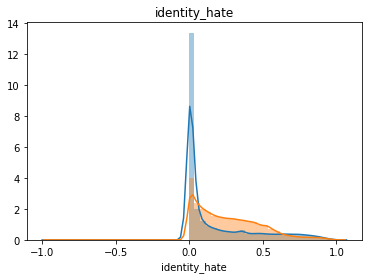

In [14]:
for l in labels:
    plt.pyplot.figure()
    plt.pyplot.title(l)
    
    for word in ['gay', 'faggot']:
        s = sub.copy()[l]
        d = y_preds[word].copy()[l]
    
        #we can cut out the most toxic comments, but - at least for the word 'shit' - that doesn't change the graph shapes much
        removalThreshold = 1 #set this to 1 to keep all comments
        d = d[s < removalThreshold]
        s = s[s < removalThreshold]
    
        d = d / (1-s) #more helpful to view how much the confidence changed *relative to how much it could have increased*
        d = d[d >= -1] #however, this adds massive negative outliers when a highly toxic (0.99+) comment has its confidence lowered
        sns.distplot(d) #which can always happen because there seems to be some noise around 0